In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
from PIL import Image
from os.path import join, isfile
from os import listdir
from tensorflow import lite
from keras import layers
from keras.models import Sequential


In [2]:
def zero_pad_num(num, length):
    result_string = num.__str__() + ".jpg"
    pads = length - (math.log(num + 1, 10)).__int__()
    if pads == 0:
        return result_string
    for j in range(pads):
        result_string = "0" + result_string
    return result_string


def crop_images(source_path, destination_path):
    base_path = os.getcwd()

    rank_path = base_path + source_path
    rank_dst = base_path + destination_path
    rank_dims = 5, 5, 35, 63 # left, top, right, bottom

    if not os.path.isdir(rank_dst):
        os.mkdir(rank_dst)

    rank_paths = []
    rank_labels = []

    for path in os.listdir(rank_path):
        if os.path.isdir(os.path.join(rank_path, path)):
            rank_paths.append(os.path.join(rank_path, path))
            rank_labels.append(path)

    for index in range(len(rank_paths)):
        path = rank_paths[index]
        onlyfiles = [join(path, file) for file in listdir(path) if isfile(join(path, file)) and file != "desktop.ini"]
        for j in range(len(rank_labels)):
            if not os.path.isdir(rank_dst + "\\" + rank_labels[j]):
                os.mkdir(rank_dst + "\\" + rank_labels[j])


        id_length = (math.log(len(onlyfiles), 10)).__int__()
        for j in range(len(onlyfiles)):
            image_to_crop = Image.open(onlyfiles[j])
            image = image_to_crop.crop(rank_dims)
            image.save(join(rank_dst + "\\" + rank_labels[index], zero_pad_num(j, id_length)))
            image_to_crop.close()

In [3]:
crop_images("\\data\\rank", "\\data\\cropped_rank")

In [4]:
batch_size = 16
img_height = 58
img_width = 30

data_dir = os.getcwd() + "\\data\\cropped_rank"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 25313 files belonging to 14 classes.
Using 20251 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 25313 files belonging to 14 classes.
Using 5062 files for validation.


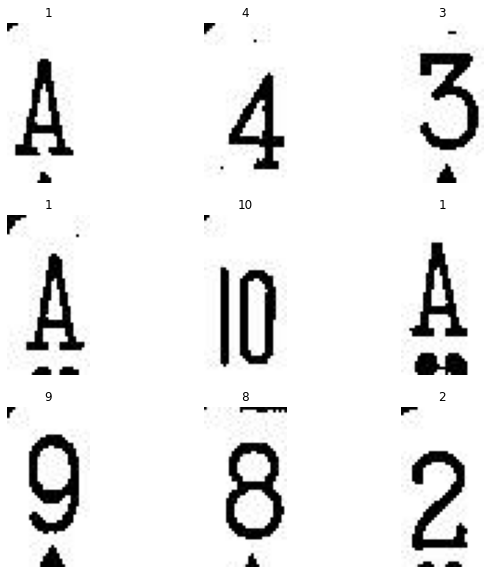

In [6]:
#See if images are there.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
    break

In [7]:
class_names = ['na', 'ace', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'jack', 'queen',
               'king']

In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break


(16, 58, 30, 3)
(16,)


In [9]:
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=autotune)
val_ds = val_ds.cache().prefetch(buffer_size=autotune)

In [10]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height,
                                            img_width,
                                            3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 58, 30, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 58, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 15, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 7, 32)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 7, 64)         1

In [13]:
epochs = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/8
1266/1266 [==============================] - 30s 16ms/step - loss: 0.1401 - accuracy: 0.9605 - val_loss: 0.0112 - val_accuracy: 0.9992
Epoch 2/8
1266/1266 [==============================] - 17s 13ms/step - loss: 0.0090 - accuracy: 0.9981 - val_loss: 0.0132 - val_accuracy: 0.9978
Epoch 3/8
1266/1266 [==============================] - 16s 13ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.0160 - val_accuracy: 0.9994
Epoch 4/8
1266/1266 [==============================] - 17s 13ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0155 - val_accuracy: 0.9996
Epoch 5/8
1266/1266 [==============================] - 16s 12ms/step - loss: 6.1705e-05 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9996
Epoch 6/8
1266/1266 [==============================] - 15s 12ms/step - loss: 1.8946e-06 - accuracy: 1.0000 - val_loss: 0.0177 - val_accuracy: 0.9996
Epoch 7/8
1266/1266 [==============================] - 16s 13ms/step - loss: 8.5364e-07 - accuracy: 1.0000 - val_loss: 0.0

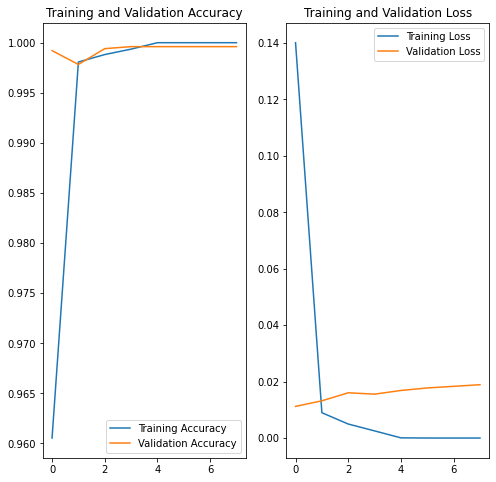

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [15]:
"""
files_to_guess = ['/content/drive/MyDrive/test_images_rank/ace.jpg',
                  '/content/drive/MyDrive/test_images_rank/two.jpg',
                  '/content/drive/MyDrive/test_images_rank/two_1.jpg',
                  '/content/drive/MyDrive/test_images_rank/two_2.jpg',
                  # '/content/drive/MyDrive/test_images_rank/three.jpg',
                  # '/content/drive/MyDrive/test_images_rank/four.jpg',
                 # '/content/drive/MyDrive/test_images_rank/five.jpg',
                  '/content/drive/MyDrive/test_images_rank/six.jpg',
                  # '/content/drive/MyDrive/test_images_rank/seven.jpg',
                  # '/content/drive/MyDrive/test_images_rank/eight.jpg',
                  # '/content/drive/MyDrive/test_images_rank/nine.jpg',
                  # '/content/drive/MyDrive/test_images_rank/ten.jpg',
                  # '/content/drive/MyDrive/test_images_rank/jack.jpg',
                  # '/content/drive/MyDrive/test_images_rank/queen.jpg',
                  # '/content/drive/MyDrive/test_images_rank/king.jpg'
                  ]

for path in files_to_guess:
  img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
  )
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  print(path)
  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )
"""

'\nfiles_to_guess = [\'/content/drive/MyDrive/test_images_rank/ace.jpg\',\n                  \'/content/drive/MyDrive/test_images_rank/two.jpg\',\n                  \'/content/drive/MyDrive/test_images_rank/two_1.jpg\',\n                  \'/content/drive/MyDrive/test_images_rank/two_2.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/three.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/four.jpg\',\n                 # \'/content/drive/MyDrive/test_images_rank/five.jpg\',\n                  \'/content/drive/MyDrive/test_images_rank/six.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/seven.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/eight.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/nine.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/ten.jpg\',\n                  # \'/content/drive/MyDrive/test_images_rank/jack.jpg\',\n                  # \'/content/d

In [16]:
model.save(os.getcwd() + "\\model\\rank_model")

INFO:tensorflow:Assets written to: C:\Users\ablaz\Dropbox\Universitet\DTU\F22\62410-cdio-project\SolitaireCDIO\python\model\rank_model\assets


In [17]:
converter = tf.lite.TFLiteConverter.from_saved_model(os.getcwd() + "\\model\\rank_model")
tflite_model = converter.convert()

with open(os.getcwd() + "\\model\\rank_model\\tflite_rank_model.tflite", 'wb') as f: f.write(tflite_model)



In [18]:
keras_file = os.getcwd() + "\\model\\rank_model\\keras\\rank.h5"
tf.keras.models.save_model(model, keras_file)
converter = lite.TFLiteConverter.from_keras_model(model)
tfmodel = converter.convert()

open(os.getcwd() + "\\model\\rank_model\\keras\\rank.tflite", "wb").write(tfmodel)

INFO:tensorflow:Assets written to: C:\Users\ablaz\AppData\Local\Temp\tmpfhl7f6us\assets


793660